In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

In [2]:
#2. Set paths & parameters
base_dir = "./data/cats_and_dogs_small"  # Change this if needed
img_size = (100, 100)  # Smaller image patch
batch_size = 32
epochs = 10

In [3]:
# 🔄 3. Image preprocessing with generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 4000 images belonging to 3 classes.
Found 1000 images belonging to 3 classes.


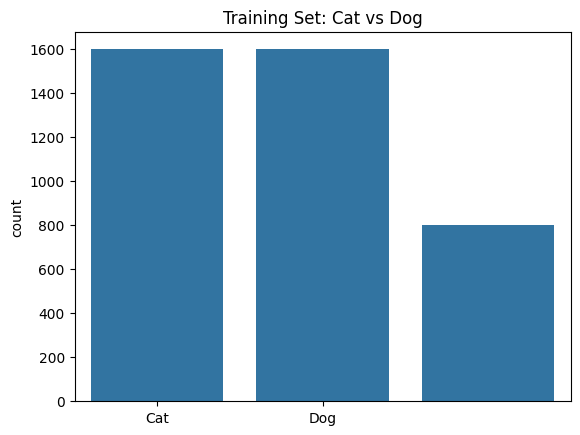

In [4]:
# 📊 4. EDA: plot label distribution
sns.countplot(x=train_gen.classes)
plt.title("Training Set: Cat vs Dog")
plt.xticks([0, 1], ["Cat", "Dog"])
plt.show()


In [6]:
# 🧠 5. Define a simple CNN model
def build_simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*img_size, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# 🔁 6. Train Simple CNN with Early Stopping
cnn_model = build_simple_cnn()

early_stop = EarlyStopping(patience=3, restore_best_weights=True)
checkpoint_cnn = ModelCheckpoint("simple_cnn.h5", save_best_only=True)

history_cnn = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop, checkpoint_cnn]
)

c:\Users\RAJEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.3965 - loss: 0.6386

125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 843ms/step - accuracy: 0.3965 - loss: 0.6380 - val_accuracy: 0.4000 - val_loss: 0.5285
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 876ms/step - accuracy: 0.4033 - loss: 0.5099 - val_accuracy: 0.4000 - val_loss: 0.5322
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 115s 919ms/step - accuracy: 0.3996 - loss: 0.4626 - val_accuracy: 0.3960 - val_loss: 0.5691
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 99s 790ms/step - accuracy: 0.4384 - loss: 0.2604 - val_accuracy: 0.4110 - val_loss: 0.6733


In [8]:
# 🧠 7. Fine-Tuned VGG16 Model
vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
vgg_base.trainable = False  # freeze pre-trained layers

vgg_model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_vgg = ModelCheckpoint("vgg16_finetuned.h5", save_best_only=True)

history_vgg = vgg_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop, checkpoint_vgg]
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3933 - loss: 0.7856 

125/125 ━━━━━━━━━━━━━━━━━━━━ 1653s 13s/step - accuracy: 0.3934 - loss: 0.7847 - val_accuracy: 0.4000 - val_loss: 0.5059
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4039 - loss: 0.5108 

125/125 ━━━━━━━━━━━━━━━━━━━━ 1646s 13s/step - accuracy: 0.4039 - loss: 0.5109 - val_accuracy: 0.4000 - val_loss: 0.4995
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1714s 14s/step - accuracy: 0.3983 - loss: 0.5599 - val_accuracy: 0.4000 - val_loss: 0.5105
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3998 - loss: 0.4741 

125/125 ━━━━━━━━━━━━━━━━━━━━ 1790s 14s/step - accuracy: 0.3998 - loss: 0.4740 - val_accuracy: 0.4000 - val_loss: 0.4946
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1814s 15s/step - accuracy: 0.3933 - loss: 0.4448 - val_accuracy: 0.4000 - val_loss: 0.5307
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1766s 14s/step - accuracy: 0.4128 - loss: 0.4186 - val_accuracy: 0.3980 - val_loss: 0.4966
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1901s 15s/step - accuracy: 0.4132 - loss: 0.3881 - val_accuracy: 0.3990 - val_loss: 0.6209


In [9]:
# 📈 8. Evaluation Function
def evaluate_model(model_path, val_gen):
    model = tf.keras.models.load_model(model_path)
    preds = model.predict(val_gen).ravel()
    pred_labels = (preds > 0.5).astype(int)
    
    print(confusion_matrix(val_gen.classes, pred_labels))
    print(classification_report(val_gen.classes, pred_labels))
    
    precision, recall, _ = precision_recall_curve(val_gen.classes, preds)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()


In [15]:
def evaluate_model(model_path, val_gen):
    model = tf.keras.models.load_model(model_path)
    preds = model.predict(val_gen).ravel()
    pred_labels = (preds > 0.5).astype(int)
    true_labels = val_gen.classes

    # 🧪 Debug output
    print("✅ Predictions shape:", preds.shape)
    print("✅ Unique values in true labels:", np.unique(true_labels))

    # Metrics
    print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
    print("\nClassification Report:\n", classification_report(true_labels, pred_labels))

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(true_labels, preds)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.show()

    # Misclassified examples
    val_filenames = np.array(val_gen.filenames)
    wrong_preds = val_filenames[true_labels != pred_labels]
    print("\n❌ Example misclassified images:")
    print(wrong_preds[:5])


In [22]:

def evaluate_model(model_path, val_gen):
    # Load best saved model
    model = tf.keras.models.load_model(model_path)

    # Predict probabilities (not labels!)
    preds = model.predict(val_gen).ravel()

    # Get true binary labels
    true_labels = val_gen.classes

    # Debug print to confirm shape and label types
    print("✅ preds shape:", preds.shape)
    print("✅ true_labels unique:", np.unique(true_labels))

    # Convert probabilities to binary predictions
    pred_labels = (preds > 0.5).astype(int)

    # 💬 Print metrics
    print("\n📊 Confusion Matrix:")
    print(confusion_matrix(true_labels, pred_labels))

    print("\n📋 Classification Report:")
    print(classification_report(true_labels, pred_labels))

    # ✅ Fix: Ensure precision-recall uses binary labels and probability scores
    try:
        precision, recall, _ = precision_recall_curve(true_labels, preds)
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.grid(True)
        plt.show()
    except ValueError as e:
        print("⚠️ Skipping precision-recall curve due to format issue:", e)

    # Show a few misclassified examples
    val_filenames = np.array(val_gen.filenames)
    wrong_preds = val_filenames[true_labels != pred_labels]
    print("\n❌ Example misclassified images:")
    print(wrong_preds[:5])


In [23]:
evaluate_model("simple_cnn.h5", val_gen)


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 465ms/step
✅ preds shape: (1000,)
✅ true_labels unique: [0 1 2]

📊 Confusion Matrix:
[[  0 400   0]
 [  0 400   0]
 [  0 200   0]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.40      1.00      0.57       400
           2       0.00      0.00      0.00       200

    accuracy                           0.40      1000
   macro avg       0.13      0.33      0.19      1000
weighted avg       0.16      0.40      0.23      1000

⚠️ Skipping precision-recall curve due to format issue: multiclass format is not supported

❌ Example misclassified images:
['test\\cat\\cat.1500.jpg' 'test\\cat\\cat.1501.jpg'
 'test\\cat\\cat.1502.jpg' 'test\\cat\\cat.1503.jpg'
 'test\\cat\\cat.1504.jpg']


c:\Users\RAJEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\RAJEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\RAJEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [24]:
evaluate_model("vgg16_finetuned.h5", val_gen)

32/32 ━━━━━━━━━━━━━━━━━━━━ 768s 24s/step
✅ preds shape: (1000,)
✅ true_labels unique: [0 1 2]

📊 Confusion Matrix:
[[  0 400   0]
 [  0 400   0]
 [  0 200   0]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.40      1.00      0.57       400
           2       0.00      0.00      0.00       200

    accuracy                           0.40      1000
   macro avg       0.13      0.33      0.19      1000
weighted avg       0.16      0.40      0.23      1000

⚠️ Skipping precision-recall curve due to format issue: multiclass format is not supported

❌ Example misclassified images:
['test\\cat\\cat.1500.jpg' 'test\\cat\\cat.1501.jpg'
 'test\\cat\\cat.1502.jpg' 'test\\cat\\cat.1503.jpg'
 'test\\cat\\cat.1504.jpg']


c:\Users\RAJEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\RAJEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\RAJEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave